# Detection of the upper line

In [2]:
import numpy as np
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import math

Import video

In [3]:
video_number = "3"
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / f"recording_{video_number}" / f"Recording_{video_number}.mp4" 
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

Opened: True, FPS: 59.94005994005994, Total Frames: 227.0


Import lines

In [4]:
# Define the iinput path for the lines CSV file
input_lines_path = project_root / "notebook"/ "lane_detection" / "intermediate_data" / "lane_lines" / f"definitive_lines_{video_number}.csv"
df = pd.read_csv(input_lines_path)

Import the template

In [5]:
# Function to display an image
def showImage(image, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

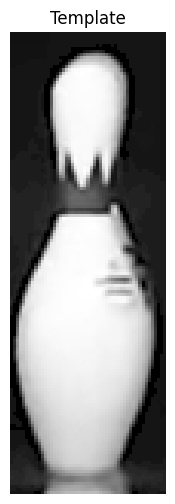

In [6]:
template = cv2.imread('intermediate_data/Template_pin_3.png', 0) # 0 for the grayscale image

template_heigth, template_width = template.shape

showImage(template, "Template")

## Functions

Draw line - lines on a single frame

In [7]:
# Funzione per estendere una linea
def extend_line(x1, y1, x2, y2, length=1000):
    # Calcola la lunghezza originale della linea
    dx, dy = x2 - x1, y2 - y1
    norm = np.sqrt(dx**2 + dy**2)  # Distanza euclidea tra i due punti

    # Evita divisioni per zero
    if norm == 0:
        return x1, y1, x2, y2  

    # Calcola i punti estesi
    x1_ext = int(x1 - length * (dx / norm))
    y1_ext = int(y1 - length * (dy / norm))
    x2_ext = int(x2 + length * (dx / norm))
    y2_ext = int(y2 + length * (dy / norm))

    return x1_ext, y1_ext, x2_ext, y2_ext

In [8]:
'''Disegna la linea sul frame'''
def write_line_on_frame(frame, line):
    # Create a copy of the original frame to draw the first line
    modified_frame = np.copy(frame)

    if line is not None:
        x1, y1, x2, y2 = line
        
       # Allunga la linea di 1000 pixel da entrambe le estremità
        x1_ext, y1_ext, x2_ext, y2_ext = extend_line(x1, y1, x2, y2, length=1000)
        
        # Disegna la linea estesa
        cv2.line(modified_frame, (x1_ext, y1_ext), (x2_ext, y2_ext), (0, 255, 0), 2)

    # return the modified frame
    return modified_frame

In [9]:
def write_lines_on_frame(frame, lines):
    for i in range(len(lines)):
        frame = write_line_on_frame(frame, lines[i])
    return frame

Extend the lines until the edges of the image

In [10]:
# --- Helper functions ---
def get_extended_line(line, img_width, img_height):
    """Extend a line to the image boundaries."""
    x1, y1, x2, y2 = line
    if x1 == x2:
        return (x1, 0), (x2, img_height)
    
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    points = []

    y_left = int(m * 0 + b)
    y_right = int(m * img_width + b)
    if 0 <= y_left <= img_height:
        points.append((0, y_left))
    if 0 <= y_right <= img_height:
        points.append((img_width, y_right))

    if m != 0:
        x_top = int((0 - b) / m)
        x_bottom = int((img_height - b) / m)
        if 0 <= x_top <= img_width:
            points.append((x_top, 0))
        if 0 <= x_bottom <= img_width:
            points.append((x_bottom, img_height))
    if len(points) < 2:
        return [x1, y1, x2, y2]
    extended_line = [points[0][0], points[0][1], points[1][0], points[1][1]]

    return extended_line

compute the determinant

In [11]:
def det(a, b):
    return a[0] * b[1] - a[1] * b[0]

Get the intersection point between 2 lines

In [12]:
def get_intersection(line_1, line_2):
    """Find the intersection point of two lines."""
    xdiff = (line_1[0] - line_1[2], line_2[0] - line_2[2])
    ydiff = (line_1[1] - line_1[3], line_2[1] - line_2[3])

    div = det(xdiff, ydiff)
    if div == 0:
        return None

    d = (det((line_1[0], line_1[1]), (line_1[2], line_1[3])), 
           det((line_2[0], line_2[1]), (line_2[2], line_2[3])))
    x = int(det(d, xdiff) / div)
    y = int(det(d, ydiff) / div)
    return x, y

Cut the part of the image that is inside the triangle created by the lines

In [13]:
def cut_frame(frame, bottom_line, left_line, rigth_line):
    """Cut the image based on the lines defined in the DataFrame."""
    width = frame.shape[1]
    height = frame.shape[0]
    # --- Get extended lines ---
    bottom_line = get_extended_line(bottom_line, width, height)
    left_line = get_extended_line(left_line, width, height)
    rigth_line = get_extended_line(rigth_line, width, height)

    # --- Get triangle intersection points ---
    int1 = get_intersection(bottom_line, left_line)
    int2 = get_intersection(bottom_line, rigth_line)
    int3 = get_intersection(left_line, rigth_line)

    if None in [int1, int2, int3]:
        raise ValueError("Could not find all three triangle points")

    triangle = np.array([int1, int2, int3])

    # --- Create mask and apply it ---
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.drawContours(mask, [triangle], 0, 255, -1)

    masked_frame = cv2.bitwise_and(frame, frame, mask=mask)

    # showImage(masked_frame, "After removing background")

    return masked_frame, triangle

Extract only brown and rose colors

In [14]:
def extract_br_frame(frame):
    # Convert frame to HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Brown range
    lower_brown = np.array([00, 00, 50])
    upper_brown = np.array([20, 255, 255])

    '''
    Hue -> Covers reddish to yellowish-brown tones
    Saturation -> Filters out grays
    Value -> Keeps medium to bright pixels, avoids too-dark shadows
    '''

    # Rose (pinkish-red) 
    lower_rose = np.array([150, 30, 200])
    upper_rose = np.array([180, 200, 255])

    '''
    Hue -> Covers magenta, pink, and rose hues
    Saturation -> Avoids overly dull or overly neon colors
    Value -> Captures only the bright parts
    '''

    # Create masks
    mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)
    mask_rose = cv2.inRange(hsv, lower_rose, upper_rose)

    # Combine both masks
    combined_mask = cv2.bitwise_or(mask_brown, mask_rose)

    # Apply the combined mask to the original frame
    brown_and_rose_frame = cv2.bitwise_and(frame, frame, mask=combined_mask)

    return brown_and_rose_frame

Get the first horizontal line where the % of black is > 98%

In [15]:
def get_upper_horizontal_line_first_estimate(frame, triangle):
    # Threshold for black (treat anything darker than this as black)
    black_thresh = 30

    # Convert masked image to grayscale for easier intensity check
    gray_masked = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Start from row y = 100
    start_y = triangle[0][1]
    height = gray_masked.shape[0]
    width = gray_masked.shape[1]
    stop_row = None

    for y in range(start_y, -1, -1):  # go from int1 down to 0
        row = gray_masked[y, :]
        non_black_pixels = np.count_nonzero(row > black_thresh)
        percentage_non_black = (non_black_pixels / len(row)) * 100

        if percentage_non_black < 2:
            stop_row = y
            print(f"Stopped at row {y} with {percentage_non_black:.2f}% non-black pixels")
            break

    if stop_row is None:
        print("No row found with <2% non-black pixels after y=100.")
        return None
    
    # # Optional: visualize the stopping row on the image
    # annotated = frame.copy()
    # cv2.line(annotated, (0, stop_row), (annotated.shape[1], stop_row), (0, 255, 0), 2)

    # plt.figure(figsize=(10, 5))
    # plt.title("Detected Stop Row")
    # plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()

        # --- Define the horizontal line  ---
    horizontal_upper_line =[0, y, width, y]

    return horizontal_upper_line

Compute euclidean distance between 2 points

In [16]:
# --- Calculate the distance between the two intersection points ---
def euclidean_distance(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

Apply template matching to detect a better line

In [17]:
def template_matching(br_frame, template, upper_horizontal_estimated, left_line, right_line):
    # computed estimated intersection between upper and lateral lines
    intersection_left = get_intersection(left_line, upper_horizontal_estimated)
    intersection_right = get_intersection(right_line, upper_horizontal_estimated)
    # compute the length of the upper line in the frame
    distance = euclidean_distance(intersection_left, intersection_right)

    # Compute the correct dimension of the template
    lane_width = 1066
    pin_height_real = 381 + 40 # 20 is the margin taken from the template
    pin_height_template = template.shape[0]
    pin_width_template = template.shape[1]

    pin_height = (pin_height_real * distance) / lane_width
    f = pin_height / pin_height_template

    template = cv2.resize(template, (0, 0), fx=f, fy=f)

    # print("Original template size:", pin_width_template, pin_height_template)
    # print("Scaling factors -> fx:", f, "fy:", f)

    new_width = int(pin_width_template * f)
    new_height = int(pin_height_template * f)

    # print("New template size:", new_width, new_height)

    # --- Template matching ---
    gray_frame = cv2.cvtColor(br_frame, cv2.COLOR_BGR2GRAY)

    # Method for doing Template Matching
    method = cv2.TM_CCOEFF

    img = gray_frame.copy()
    result = cv2.matchTemplate(img, template, method) # This performs Convolution, the output will be (Width - w + 1, Height - h + 1)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result) # This returns min, max values, min, max locations
    location = max_loc
        
    bottom_right = (location[0] + new_width, location[1] + new_height)
    # print(f"Coordinates of the bottom right location:", bottom_right)

    # # Optional: visualize the template matching result
    # img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # cv2.rectangle(img, location, bottom_right, color=(0,255,0), thickness=2)
    # cv2.circle(img, bottom_right, 8, (0, 0, 255), -1)
    # showImage(img, "Pin detection")

    return bottom_right

Calculate the angle of the line

In [18]:
# Function to calculate the angle of a line
def calculate_angle(x1, y1, x2, y2):
    return math.degrees(math.atan2(y2 - y1, x2 - x1))

Correct the inclination of the upper line

In [19]:
def correct_inclination(bottom_right, bottom_line, frame):
    slope_bottom_line = np.deg2rad(calculate_angle(bottom_line[0], bottom_line[1], bottom_line[2], bottom_line[3]))
    # Lenght between the detected point and the point I want to create
    length = 100 

    # Calculate two points along the line
    ux1 = int(bottom_right[0] - length)
    uy1 = int(bottom_right[1] - slope_bottom_line/2 * length) # TODO: change the /2 because it is wrong
    ux2 = int(bottom_right[0] + length)
    uy2 = int(bottom_right[1] + slope_bottom_line/2 * length) # TODO: change the /2 because it is wrong

    # Calculate the extended line points
    width = frame.shape[1]
    height = frame.shape[0]
    upper_line = get_extended_line([ux1, uy1, ux2, uy2], width, height)

    return upper_line

Main

In [20]:
def get_upper_line(frame, bottom_line, left_line, right_line, template):
    cutted_frame, triangle = cut_frame(frame, bottom_line, left_line, right_line)
    br_frame = extract_br_frame(cutted_frame)
    upper_horizontal_estimated = get_upper_horizontal_line_first_estimate(br_frame, triangle)
    bottom_rigth_point_pin = template_matching(cutted_frame, template, upper_horizontal_estimated, left_line, right_line)
    
    upper_line = correct_inclination(bottom_rigth_point_pin, bottom_line, frame)# TO CHANGE
    return upper_line

Generate video

In [21]:
# Reset the video to the beginning
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Define the codec and create a VideoWriter object to save the modified frames
output_path = project_root / "data" / f"recording_{video_number}" / "All_Lines_video_non_processed.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' codec for MP4 format
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(str(output_path), fourcc, fps, (frame_width, frame_height))

# Loop through each frame in the video
frame_index = 0
lines_array = []
intersection_points = []
print(len(df))
while frame_index < len(df):
    ret, video_frame = cap.read()
    if not ret:
        print("End of video or failed to read the frame at iteration", frame_index)
        break
    
    frame_data = df.iloc[frame_index]
    # --- Extract line endpoints ---
    bottom_line = [frame_data['hx1'], frame_data['hy1'], frame_data['hx2'], frame_data['hy2']]
    left_line = [frame_data['lx1'], frame_data['ly1'], frame_data['lx2'], frame_data['ly2']]
    rigth_line = [frame_data['rx1'], frame_data['ry1'], frame_data['rx2'], frame_data['ry2']]

    # Compute the three lines in the frame
    upper_line = get_upper_line(video_frame, bottom_line, left_line, rigth_line, template) 
    all_lines = [bottom_line, left_line, rigth_line, upper_line]
    intersection_points.append([get_intersection(bottom_line, left_line), get_intersection(bottom_line, rigth_line), get_intersection(upper_line, left_line), get_intersection(upper_line, rigth_line)])

    if all_lines is None:
        print("No lines found in frame", frame_index)
        modified_frame = video_frame
        
    else:
        # draw the lines on the frame   
        modified_frame = write_lines_on_frame(video_frame, all_lines)
        # add lines to the output array
        lines_array.append(all_lines)

    # Write the modified frame to the output video
    out.write(modified_frame)

    # Increment the frame index
    frame_index += 1

# Release the video capture and writer objects
# cap.release()
out.release()

print(f"Adjusted video saved to {output_path}")

227
Stopped at row 443 with 0.78% non-black pixels
Stopped at row 443 with 0.78% non-black pixels
Stopped at row 443 with 0.78% non-black pixels
Stopped at row 443 with 1.67% non-black pixels
Stopped at row 441 with 1.15% non-black pixels
Stopped at row 439 with 1.15% non-black pixels
Stopped at row 437 with 1.15% non-black pixels
Stopped at row 435 with 1.15% non-black pixels
Stopped at row 437 with 1.82% non-black pixels
Stopped at row 435 with 1.56% non-black pixels
Stopped at row 433 with 1.51% non-black pixels
Stopped at row 431 with 1.56% non-black pixels
Stopped at row 431 with 1.72% non-black pixels
Stopped at row 429 with 0.99% non-black pixels
Stopped at row 427 with 0.68% non-black pixels
Stopped at row 425 with 0.94% non-black pixels
Stopped at row 425 with 1.61% non-black pixels
Stopped at row 423 with 1.46% non-black pixels
Stopped at row 421 with 1.72% non-black pixels
Stopped at row 419 with 1.56% non-black pixels
Stopped at row 417 with 1.20% non-black pixels
Stopped a

Save the 4 points in a CSV

In [22]:
# Create a DataFrame from the intersection_points and frame indices
columns = ['Frame', 'bottom_left_x', 'bottom_left_y', 'bottom_right_x', 'bottom_right_y', 'up_left_x', 'up_left_y', 'up_right_x', 'up_right_y']
data = []

for frame_idx, points in enumerate(intersection_points):
    if points is not None and len(points) == 4:
        bottom_left, bottom_right, up_left, up_right = points
        data.append([frame_idx, bottom_left[0], bottom_left[1], bottom_right[0], bottom_right[1], up_left[0], up_left[1], up_right[0], up_right[1]])

# Create the DataFrame
intersection_df = pd.DataFrame(data, columns=columns)

# Display the DataFrame
# print(intersection_df)

output_path = project_root / "data" / "auxiliary_data" / "lane_points" / f"lane_points_raw_{video_number}.csv"
intersection_df.to_csv(output_path, index=False)
print(f"Intersection points saved to {output_path}")

Intersection points saved to C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\data\auxiliary_data\lane_points\lane_points_raw_3.csv
